In [1]:
%load_ext autoreload
%autoreload 2

import json
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
from ipywidgets import interact
import altair as alt

if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('..')

plt.style.use('ggplot')
alt.themes.enable('fivethirtyeight')
CHARTS_DIR = Path('../covid19-analysis/layouts/partials/covid')

In [2]:
from fetch import fetch_timeseries, TS_URL

df = fetch_timeseries(TS_URL)
df_long = df.stack().rename('count').rename_axis(index={None: 'kind'})

display(df.head())
display(df_long.head())

# Timeseries

confirmed  deaths  recovered
country     date                                    
Afghanistan 2020-01-22          0       0          0
            2020-01-23          0       0          0
            2020-01-24          0       0          0
            2020-01-25          0       0          0
            2020-01-26          0       0          0

country      date        kind     
Afghanistan  2020-01-22  confirmed    0
                         deaths       0
                         recovered    0
             2020-01-23  confirmed    0
                         deaths       0
Name: count, dtype: int64

In [7]:
from IPython.display import display
from charts import make_ts_chart, make_ts_selections, make_data_long
from charts import make_map, kind_schemes, make_map_data, countries, make_map_data

# alt.data_transformers.enable('default', max_rows=None)
alt.data_transformers.enable('data_server')
alt.renderers.enable('html')

data_long = make_data_long(df_long)
selection_legend, selection_tooltip = make_ts_selections(data_long)
ts_chart = make_ts_chart(data_long, *make_ts_selections(data_long))
ts_chart

# Map

map_data = make_map_data(data_long, countries)
map_chart = make_map(map_data, kind_schemes)
selection_country_click = alt.selection_single(
    fields=['country'],
    name='Country of',
    empty='all',
)

chart = (map_chart
 .encode(color=alt.condition(selection_country_click, 'count:Q', alt.value('lightgray'), scale=alt.Scale(scheme='oranges', type='log', base=10)))
 .add_selection(selection_country_click)
 .add_selection(selection_legend)
 .transform_filter(selection_legend)
         .properties(width=700, height=400)
 | 
         ts_chart.add_selection(selection_country_click)
         .transform_filter(selection_country_click)
         .transform_aggregate(
            count='sum(count)',
            groupby=['kind', 'date']
         ).properties(width=700, height=400, title='Evolution')
)

# chart.save(str(CHARTS_DIR / 'combined.html'))
chart

alt.HConcatChart(...)

# Correlations

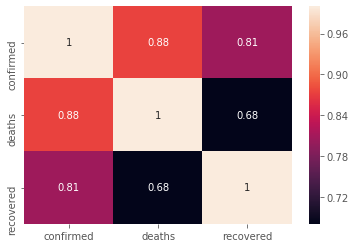

In [5]:
import seaborn as sns

df.groupby('country').apply(lambda f: f.fillna(method='ffill')).fillna(0).corr().pipe(sns.heatmap, annot=True)

In [6]:
df.groupby(['date']).sum().corr()

,confirmed,deaths,recovered
confirmed,1.000000,0.997010,0.907882
deaths,0.997010,1.000000,0.891163
recovered,0.907882,0.891163,1.000000


In [7]:
def correlation_lags(df, column='deaths', max_lag=20, group=False):
    def series_corr(f):
        return pd.Series({t: f['confirmed'].shift(t).iloc[:-20].corr(f[column]) for t in range(max_lag)})
    if group:
        return df.groupby('country').apply(series_corr).idxmax(axis=1)
    else:
        return df.pipe(series_corr).idxmax(axis=0)

world_ts = df.groupby('date').sum()
days_to_death = correlation_lags(world_ts, 'deaths')
days_to_recov = correlation_lags(world_ts, 'recovered')

In [8]:
days_to_death, days_to_recov

(6, 17)

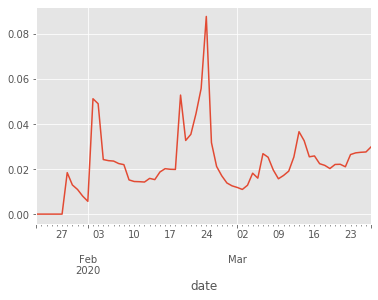

In [9]:
fatality_rates = (df.join(correlation_lags(df, group=True, column='deaths').rename('days_to_death').fillna(0).astype(int))
                  .groupby('country')
                  .apply(lambda g: g.deaths.div(g.confirmed.shift(g['days_to_death'].iloc[0])))
                  .reset_index(0, drop=True)
                 )
fatality_rates.groupby('date').mean().plot()

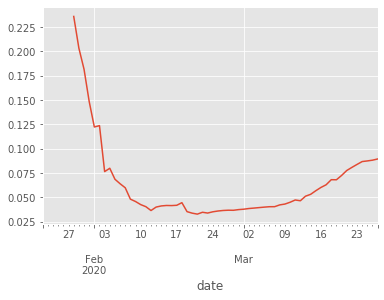

In [10]:
world_ts.deaths.div(world_ts.confirmed.shift(days_to_death)).plot()